In [43]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, train, fit_rocket, fit_classifier
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff
### TODO: remove
from temp import find_best


subject_id = 5

eeg_data_1 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

In [44]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, 
                      eeg_data_2, 
                      #eeg_data_3
                     ], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, 
                          gradcpt_data_2,
                          #gradcpt_data_3
                         ], ignore_index=True)

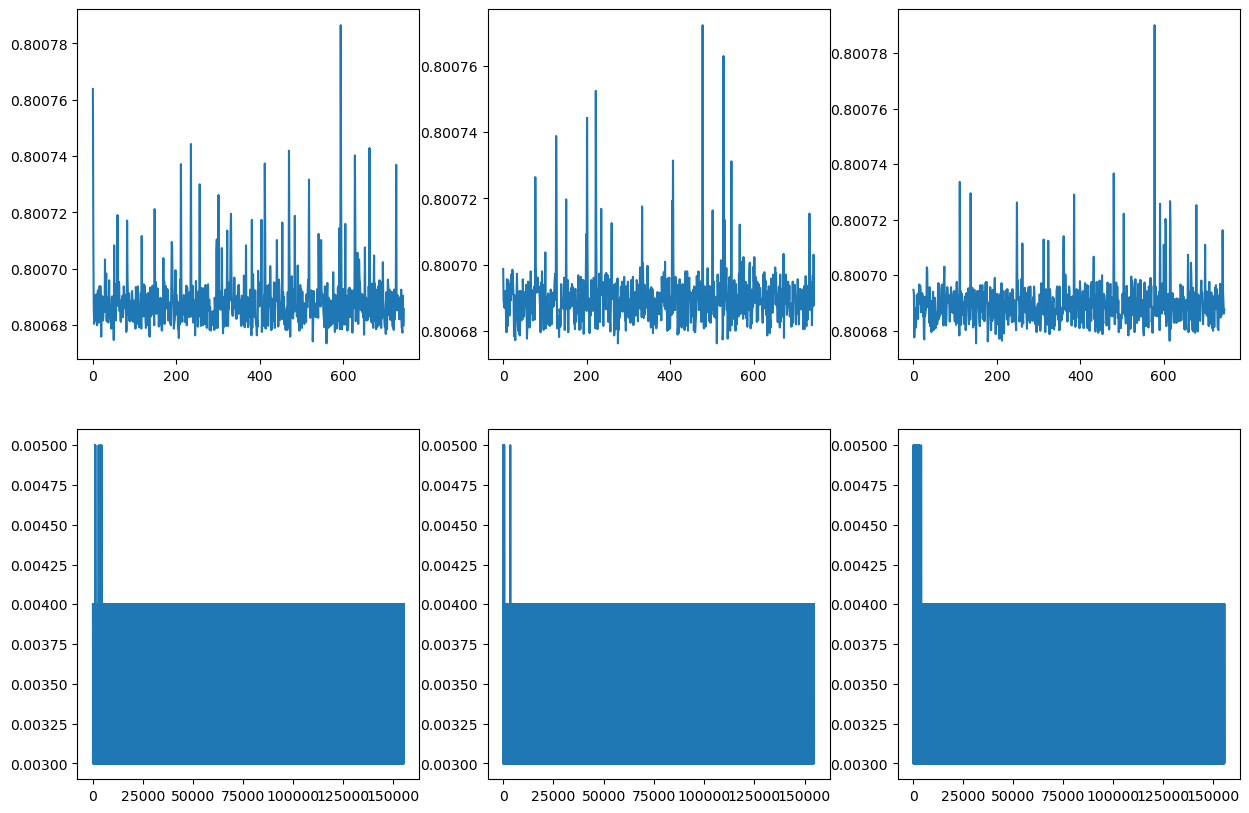

In [45]:
eeg_trials = [eeg_data_1, eeg_data_2, eeg_data_3]
gradcpt_trials = [gradcpt_data_1, gradcpt_data_2, gradcpt_data_3]
plot_sample_durations(eeg_trials, gradcpt_trials)

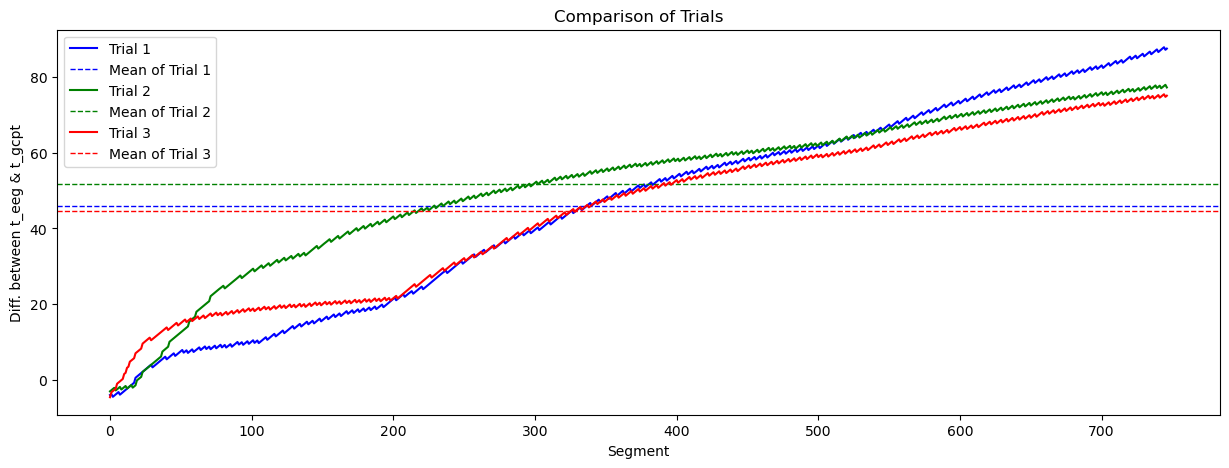

In [46]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### z-normalization

In [47]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [48]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [49]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

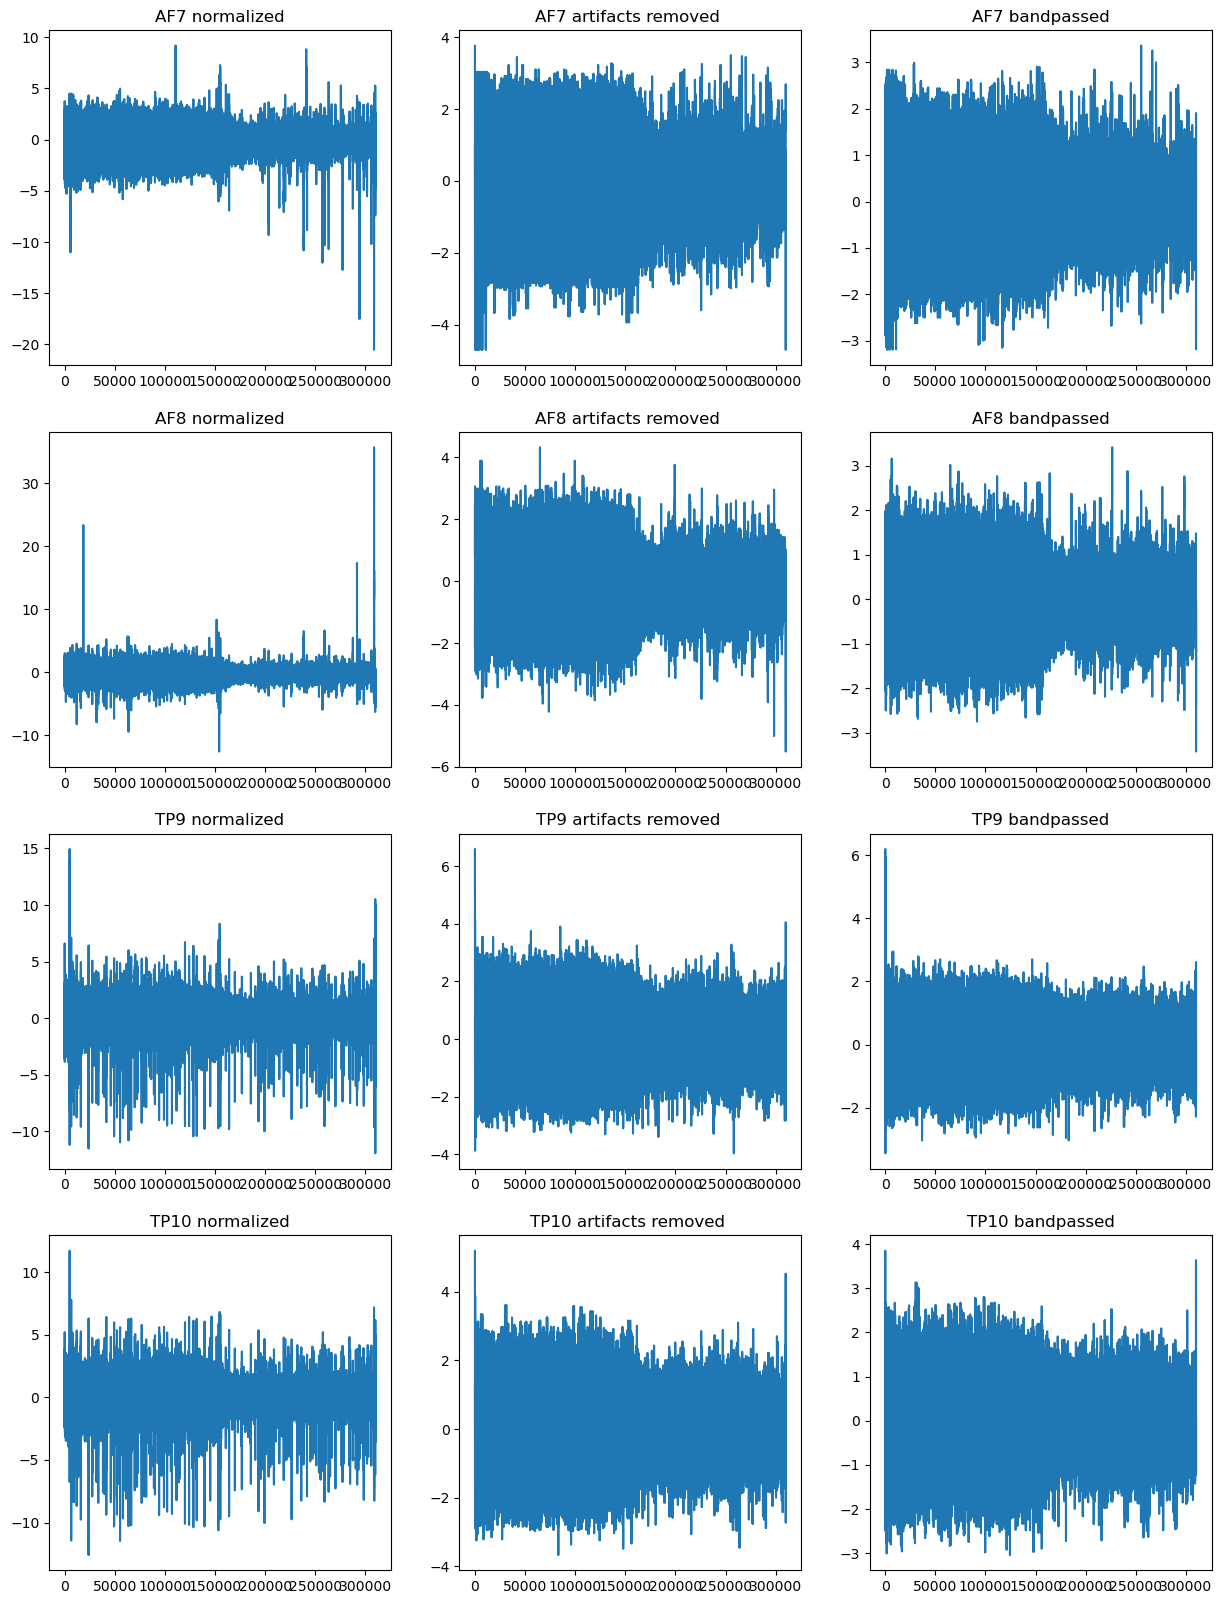

In [50]:
plot_preprocessing(channels=channels, eeg_df=eeg_data)

### Segment

In [51]:
all_channel_segments = []

# Process each channel
for channel in channels:
    # Segment the current EEG data for the channel
    channel_segments = segment_column(eeg_data[f'{channel}_bandpassed'], gradcpt_data)
    
    # Convert the list of segments into a numpy array with shape (number of segments, 205)
    # Not introducing the singleton dimension this time
    channel_segments_array = np.array(channel_segments).reshape(-1, 205)
    
    # Append the reshaped segments for this channel to the list
    all_channel_segments.append(channel_segments_array)

# Stack the channel segments along a new axis to combine them
# This should result in a shape: (number of segments, number of channels, 205)
combined_segments = np.stack(all_channel_segments, axis=1)
labels = np.array(gradcpt_data['in_the_zone'])

print(f"Corrected combined segments shape: {combined_segments.shape}")
print(f"Labels shape: {labels.shape}")

Corrected combined segments shape: (1494, 4, 205)
Labels shape: (1494,)


## Detach-ROCKET

### Combined features

In [52]:
X = combined_segments
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_af7, X_test_af7 = X_train[:,0:1,:], X_test[:,0:1,:]
X_train_af8, X_test_af8 = X_train[:,1:2,:], X_test[:,1:2,:]
X_train_tp9, X_test_tp9 = X_train[:,2:3,:], X_test[:,2:3,:]
X_train_tp10, X_test_tp10 = X_train[:,3:4,:], X_test[:,3:4,:]

In [53]:
model_combined_features = fit_rocket(X_train, X_test, y_train, y_test, trade_off=0.1 ,graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 75.33%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 27.00
Train Accuraccy Detach Model: 100.00%
-------------------------
Test Accuraccy Full Model: 52.00%
Test Accuraccy Detach-ROCKET: 54.22%
-------------------------
Optimal Model Size: 25.03% of full model


In [54]:
X_train_transformed = model_combined_features.transform_features(X_train)
X_test_transformed = model_combined_features.transform_features(X_test)

In [55]:
fit_classifier(X_train_transformed, X_test_transformed, y_train, y_test);

Training Accuracy:
0.8486997635933806
Testing Accuracy:
0.5155555555555555

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.54      0.49      0.52       118
           1       0.49      0.54      0.52       107

    accuracy                           0.52       225
   macro avg       0.52      0.52      0.52       225
weighted avg       0.52      0.52      0.52       225


Confusion Matrix (Test):
 [[58 60]
 [49 58]]


In [56]:
find_best(X_train, X_test, y_train, y_test);

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 74.63%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 85.00
Train Accuraccy Detach Model: 70.37%
-------------------------
######################
######################
new best at p=0.01
Training Accuracy:
0.6950354609929078
Testing Accuracy:
0.5777777777777777

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.61      0.53      0.57       118
           1       0.55      0.64      0.59       107

    accuracy                           0.58       225
   macro avg       0.58      0.58      0.58       225
weighted avg       0.58      0.58      0.58       225


Confusion Matrix (Test):
 [[62 56]
 [39 68]]
######################
######################
TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 74.63%
-------------------------
TRAINING RESULTS Detach M

## Separate channels

### AF7

In [57]:
model_af7 = fit_rocket(X_train_af7, X_test_af7, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 4832.93
Train Accuraccy Full ROCKET: 91.57%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 47.00
Train Accuraccy Detach Model: 95.90%
-------------------------
Test Accuraccy Full Model: 56.44%
Test Accuraccy Detach-ROCKET: 56.44%
-------------------------
Optimal Model Size: 8.97% of full model


In [58]:
X_train_transformed_af7 = model_af7.transform_features(X_train_af7)
X_test_transformed_af7 = model_af7.transform_features(X_test_af7)

In [59]:
fit_classifier(X_train_transformed_af7, X_test_transformed_af7, y_train, y_test);

Training Accuracy:
0.9125295508274232
Testing Accuracy:
0.56

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.58      0.58      0.58       118
           1       0.54      0.54      0.54       107

    accuracy                           0.56       225
   macro avg       0.56      0.56      0.56       225
weighted avg       0.56      0.56      0.56       225


Confusion Matrix (Test):
 [[68 50]
 [49 58]]


### AF8

In [60]:
model_af8 = fit_rocket(X_train_af8, X_test_af8, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 615848.21
Train Accuraccy Full ROCKET: 58.55%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 71.00
Train Accuraccy Detach Model: 73.21%
-------------------------
Test Accuraccy Full Model: 51.56%
Test Accuraccy Detach-ROCKET: 55.11%
-------------------------
Optimal Model Size: 2.61% of full model


In [61]:
X_train_transformed_af8 = model_af8.transform_features(X_train_af8)
X_test_transformed_af8 = model_af8.transform_features(X_test_af8)

In [62]:
fit_classifier(X_train_transformed_af8, X_test_transformed_af8, y_train, y_test);

Training Accuracy:
0.6485421591804571
Testing Accuracy:
0.5155555555555555

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.55      0.44      0.49       118
           1       0.49      0.60      0.54       107

    accuracy                           0.52       225
   macro avg       0.52      0.52      0.51       225
weighted avg       0.52      0.52      0.51       225


Confusion Matrix (Test):
 [[52 66]
 [43 64]]


### TP9

In [63]:
model_tp9 = fit_rocket(X_train_tp9, X_test_tp9, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 67.53%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 43.00
Train Accuraccy Detach Model: 97.87%
-------------------------
Test Accuraccy Full Model: 56.44%
Test Accuraccy Detach-ROCKET: 49.33%
-------------------------
Optimal Model Size: 11.01% of full model


In [64]:
X_train_transformed_tp9 = model_tp9.transform_features(X_train_tp9)
X_test_transformed_tp9 = model_tp9.transform_features(X_test_tp9)

In [65]:
fit_classifier(X_train_transformed_tp9, X_test_transformed_tp9, y_train, y_test);

Training Accuracy:
0.7494089834515366
Testing Accuracy:
0.5688888888888889

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.60      0.52      0.56       118
           1       0.54      0.63      0.58       107

    accuracy                           0.57       225
   macro avg       0.57      0.57      0.57       225
weighted avg       0.57      0.57      0.57       225


Confusion Matrix (Test):
 [[61 57]
 [40 67]]


### TP10

In [66]:
model_tp10 = fit_rocket(X_train_tp10, X_test_tp10, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 4832.93
Train Accuraccy Full ROCKET: 92.75%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 63.00
Train Accuraccy Detach Model: 86.21%
-------------------------
Test Accuraccy Full Model: 57.78%
Test Accuraccy Detach-ROCKET: 60.89%
-------------------------
Optimal Model Size: 3.94% of full model


In [67]:
X_train_transformed_tp10 = model_tp10.transform_features(X_train_tp10)
X_test_transformed_tp10 = model_tp10.transform_features(X_test_tp10)

In [68]:
fit_classifier(X_train_transformed_tp10, X_test_transformed_tp10, y_train, y_test);

Training Accuracy:
0.8400315208825847
Testing Accuracy:
0.6177777777777778

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.66      0.56      0.61       118
           1       0.58      0.68      0.63       107

    accuracy                           0.62       225
   macro avg       0.62      0.62      0.62       225
weighted avg       0.62      0.62      0.62       225


Confusion Matrix (Test):
 [[66 52]
 [34 73]]


### stacked

In [69]:
X_train_transformed_stacked = np.hstack((X_train_transformed_af7, X_train_transformed_af8, X_train_transformed_tp9, X_train_transformed_tp10))
X_test_transformed_stacked = np.hstack((X_test_transformed_af7, X_test_transformed_af8, X_test_transformed_tp9, X_test_transformed_tp10))

In [70]:
fit_classifier(X_train_transformed_stacked, X_test_transformed_stacked, y_train, y_test);

Training Accuracy:
0.9992119779353822
Testing Accuracy:
0.5555555555555556

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.59      0.50      0.54       118
           1       0.53      0.62      0.57       107

    accuracy                           0.56       225
   macro avg       0.56      0.56      0.56       225
weighted avg       0.56      0.56      0.55       225


Confusion Matrix (Test):
 [[59 59]
 [41 66]]
